# Cosmic K-long study

## 1. Cosmic proton

Open init.sh, change run name to RUN_NAME="run-2024-07-cosmic-proton". 
Add a 2.67 GeV cut before geant4 to reduce the run time.   
In process_cosmic.py (line 220), add       

```python
if energy < 2.67e3:    
    continue
```

Run PARMA to generate protons.

```bash
./run_cosmic.sh  -n 500000 -r 0 -s Run -p 1 -d -f -c
```

The ratio of GEANT4 events over 500k is the passage fraction for the threshold cut, which is about 1%. 

For the above run with 500k PARMA events, about 5100 events left after the cut, which takes 600 seconds (10 minutes) in GEANT4. 
The output file is 19 MB (hits) and 5.67 MB (steps), with about 500 kaons


### 1.1 proton generated KL/KS

Geant4 based simulation needs to be modified to record all steps related to kaons.
Extracting kaons from the step file: `extract_kaons.py`

For 5M protons above threshold, need to split into 100 runs of 5M PARMA events.
* Storage: 26 GB
* Time: 2 hour per job/ 200 CPU hours total
* To load the result, the python function in this notebook takes 1 seconds for 500 kaons. --> 1k seconds to load 500k kaons. Should be fine without using c





./run_cosmic.sh  -n 5000 -r 0 -s Run -p 1 -d -f -c

In [2]:
import pickle, joblib
import numpy as np
from matplotlib.pyplot import *
import ROOT
import uproot
from tqdm import tqdm
from importlib import reload

import copy
import glob
import sys, os
import re
from collections import namedtuple
# particle = namedtuple('particle', ['X_S', 'Y_S', 'Z_S', 'X_END_S', 'Y_END_S', 'Z_END_S', 'PX_S', 'PY_S', 'PZ_S', 'PDG', 'TRACK', 'TRACK_PARENT', "TRACK_STATUS", 'entry'])
# particle = namedtuple('particle', ['X_S', 'Y_S', 'Z_S', 'X_END_S', 'Y_END_S', 'Z_END_S', 'PX_S', 'PY_S', 'PZ_S', 'PDG', 'TRACK', 'TRACK_PARENT', "TRACK_STATUS", 'TRACK_DECAYED', 'entry'])
particle = namedtuple('particle', ['X_S', 'Y_S', 'Z_S', 'X_END_S', 'Y_END_S', 'Z_END_S', \
                                   'PX_S', 'PY_S', 'PZ_S', 'PX_END_S', 'PY_END_S', 'PZ_END_S', \
                                   'PDG', 'TRACK', 'TRACK_PARENT', "TRACK_STATUS", 'TRACK_DECAYED', 
                                   'entry', 'filenumber'])


from muhelper.helper_pytracker import visualization
import muhelper

def append_dicts(dict1,dict2):
    dict_combined=dict()
    for key in dict1:
        if key in dict2:
            dict_combined[key]=np.concatenate((dict1[key],dict2[key]))
    return dict_combined

    
def load_all(filelist, loader=None, datatype="dict", verbose=True, list_append_axis=0):
    """
    INPUT:
    ---
    filelist: list
        A list of files to be loaded
    loader: str or function
        Choose one of {"npy", "joblib", "pickle"}, or provide your custom load function for one file.
        Default is automatically detecting based on filename.
    datatype: str
        One of {"dict", "list"}
        Default is dict
    verbose: bool
        Print out progress. 
        Default is true
    list_append_axis: int
        The axis to join the list if the datatype is "list"
        Default is 0, concatenate data from all files on axis 0.
    """
    import types
    
    if len(filelist)==0:
        return
    loader=filelist.split(".")[-1] if loader is None else loader
    
    # Make the load function depending on file format
    if loader=="npy":
        load = lambda fname: np.load(fname, allow_pickle=True).item()
    elif loader=="joblib":
        load = lambda fname: joblib.load(fname)
    elif isinstance(loader, types.FunctionType):
        load = loader
    else:
        raise Exception("Sorry, could not detect the file format. Please specify one of the following [npy, joblib], or a lambda function")
    
    data = load(filelist[0])
    datatype = type(data).__name__ if datatype is None else datatype
    for i, fname in enumerate(filelist[1:]):
        if verbose:
            print(f"{i+2}/{len(filelist)}, {fname}", end="\r")
        data_temp = load(fname)
        if datatype=="dict":
            data = append_dicts(data, data_temp)
        elif datatype=="list":
            data = np.concatenate((data,data_temp),axis=list_append_axis)
    return data

Welcome to JupyROOT 6.28/10


---

In [3]:
run_dir = "/project/rrg-mdiamond/data/MATHUSLA//simulation/run-2024-07-cosmic-proton/"

## Get all step files
filename_steps = glob.glob(run_dir+"/SimOutput/cosmic/run_*/*/*/run_step_data_kaons.joblib")

# Exclude run0 and runs that did not complete
length = len(filename_steps)
for i in range(length)[::-1]:
    if "/run_0/" in filename_steps[i]:
        del filename_steps[i]
length = len(filename_steps)        
for i in range(length)[::-1]:        
    filename_sim = filename_steps[i].replace("run_step_data.root", "run0.root")
    if not os.path.exists(filename_sim):
        del filename_steps[i]   
print("Number of [step] files found", len(filename_steps))

## Get all raw files 
filename_sims=[]
for filename in filename_steps:
    f  = filename_steps[i].replace("run_step_data_kaons.joblib", "run0.root")
    filename_sims.append(f)
        
## Get all input files
filename_inputs=[]
for filename in filename_steps:
    f  = filename.replace("SimOutput", "SimInput")
    f = os.path.dirname(os.path.dirname(os.path.dirname(f))) + "/combined_*_events.npy"
    f = glob.glob(f)[0]
    filename_inputs.append(f)

## Get all reconstruction files
filename_recons=[]
for filename in filename_steps:
    run_number = re.search(r'run_(\d+)', filename).group(1)
    filename_recon = run_dir+f"/DigiOutput/cosmic_run_{run_number}/0/stat0.pkl"
    if os.path.exists(filename_recon):
        filename_recons.append(filename_recon)
    else:
        print("file not found!")   
print("Number of [recon] files found", len(filename_steps))

Number of [step] files found 769
Number of [recon] files found 769


In [47]:
filenamesave = {"filename_steps":filename_steps,
               "filename_sims":filename_sims,
               "filename_inputs":filename_inputs,
               "filename_recons":filename_recons}
joblib.dump( filenamesave, "file_list.joblib")

['file_list.joblib']

In [88]:
run_numbers = []
for f in filename_steps:
    run_number = re.search(r'run_(\d+)', f).group(1)
    run_numbers.append(int(run_number))
    
run_numbers.sort()
print(*run_numbers, sep=",")
print(len(run_numbers))

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,113,116,118,119,120,121,122,123,124,125,128,129,130,131,132,133,134,135,136,138,139,140,141,142,144,145,146,148,149,150,151,154,156,158,159,161,163,164,165,166,167,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,187,189,190,191,192,193,194,197,198,200,201,203,204,205,208,209,210,211,212,215,216,217,218,219,221,224,225,226,227,228,229,230,231,232,233,234,237,238,239,240,241,242,243,245,247,248,249,250,251,252,253,255,256,257,258,259,260,262,263,264,265,266,267,268,269,270,273,274,275,276,277,278,280,281,282,283,285,286,287,289,291,295,296,297,299,300,301,302,304,305,306,307,310,311,313,314,315,316,317,318,319,320,322,324,325,326,327,328,329,330,331,

### 1. Protons

In [7]:
# filename_raws= glob.glob(run_dir+"/SimInput/cosmic/run_?/combined_*_events.npy") + glob.glob(run_dir+"/SimInput/cosmic/run_??/combined_*_events.npy") + glob.glob(run_dir+"/SimInput/cosmic/run_100/combined_*_events.npy")
# number_of_raw_from_parma_per_file = 5e6
# n_raw_total = number_of_raw_from_parma_per_file*len(filename_raws)

# # Exclude run0
# length = len(filename_raws)
# for i in range(length)[::-1]:
#     if "/run_0/" in filename_raws[i]:
#         del filename_raws[i]
# print("Number of files found", len(filename_raws))
# print("First file", filename_raws[0])

In [7]:
# Load all files
data_raw = load_all(filename_raws, loader="npy", datatype="dict", verbose=True)
print("All files loaded")

Number of files 101
First file /project/rrg-mdiamond/data/MATHUSLA//simulation/run-2024-07-cosmic-proton//SimInput/cosmic/run_75/combined_52200_events.npy
All files loadedt/rrg-mdiamond/data/MATHUSLA//simulation/run-2024-07-cosmic-proton//SimInput/cosmic/run_13/combined_51585_events.npy


In [8]:
p_h = np.linalg.norm([data_raw["py"],data_raw["px"]], axis=0)
p = np.linalg.norm([data_raw["py"],data_raw["px"],data_raw["pz"]], axis=0)
fraction_above_Q = len(p)/n_raw_total
print("Fraction of proton above Q:", fraction_above_Q)
print("Number of protons above threshold", len(p))

# Total flux 0.000303893 [/cm2/s]
# Radius: 35.0 [meter]
# --> Rate is 11678 [Hz], 0.000303893/(3.14*3500**2)
# --> 5M event is 428 [s], 5e6/11678 

Fraction of proton above Q: 0.01039399603960396
Number of protons above threshold 5248968


(1613.0, 2000000.0)

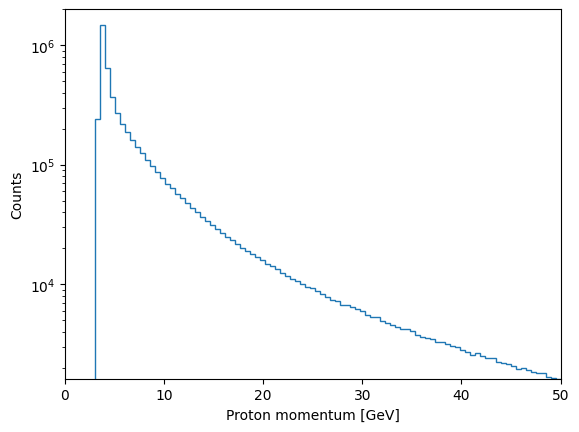

In [10]:
bins=np.linspace(0,50,100)
n,ibins = np.histogram(p[:10000000]*0.001, bins=bins)
weight = 1/np.diff(bins) /sum(n)
stairs(n, ibins)
yscale("log")
xlabel("Proton momentum [GeV]")
ylabel("Counts")
margins(0,0)
ylim(top=2e6)

### 2. Kaons

In [9]:
filename_root="/project/rrg-mdiamond/data/MATHUSLA//simulation/run-2024-07-cosmic-proton//SimOutput/cosmic/run_101/20240730/141054/run_step_data.root"

In [28]:

# filename_root="/project/rrg-mdiamond/data/MATHUSLA//simulation/run-2024-07-cosmic-proton//SimOutput/cosmic/run_101/20240730/141054/run_step_data.root"
# # results = extract_kaon(filename_steps[0])

results = load_all(filename_steps, loader="joblib", datatype="list", verbose=True)
data = np.array(results)
del results

In [36]:
data[10000]

array(['73767.71408275266', '-10155.052580858512', '401.5910557560802',
       '73784.41142422475', '-10164.202776665503', '415.6434910867481',
       '346.0959133719491', '-189.66165246412945', '291.2733412681206',
       '346.0959133719491', '-189.66165246412945', '291.2733412681206',
       '310', '58324', '377', '2', '1', '37552', '83'], dtype='<U32')

Number of KL 260379
Number of KS 260496
Number of upward KL 24362
Number of upward KS 24158
Number of upward decaying KL 13644
Number of upward decaying KS 23701
Number of upward decaying KL in mathusla 271
Number of upward decaying KS in mathusla 26


Text(0.5, 1.0, 'Generation and decay position of all KL/KS')

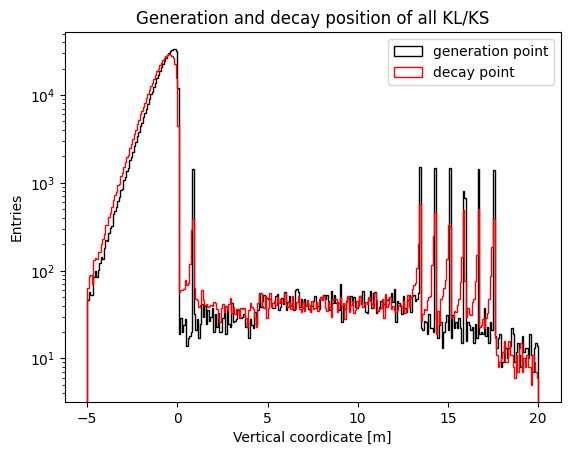

In [6]:
k_x = data[:,0]
k_y = data[:,1]
k_z = data[:,2]
k_x_end = data[:,0+3]
k_y_end = data[:,1+3]
k_z_end = data[:,2+3]
k_px = data[:,0+9]
k_py = data[:,1+9]
k_pz = data[:,2+9]
k_pdg = data[:, 12]
k_status =  data[:, 15]
k_isdecay =  data[:, 16]
k_px_delat = data[:,2+9]-data[:,2+6]
k_pabs = np.linalg.norm([k_px,k_py,k_pz], axis=0)
k_theta = np.arccos(-k_pz/k_pabs)


mask_kl = k_pdg==130
mask_ks = k_pdg==310
mask_upward = k_pz<0
mask_decay = k_isdecay==1
mask_inmathusla = (-k_z_end/1000>1) & (-k_z_end/1000<12.6+0.8) &(abs(k_x/1000-90)<19.5) & (abs(k_y/1000)<19.5)
mask_sensitive = mask_upward&mask_decay&mask_inmathusla
print("Number of KL", sum(mask_kl))
print("Number of KS", sum(mask_ks))
print("Number of upward KL", sum(mask_kl&mask_upward))
print("Number of upward KS", sum(mask_ks&mask_upward))
print("Number of upward decaying KL", sum(mask_kl&mask_upward&mask_decay))
print("Number of upward decaying KS", sum(mask_ks&mask_upward&mask_decay))
print("Number of upward decaying KL in mathusla", sum(mask_kl&mask_upward&mask_decay&mask_inmathusla))
print("Number of upward decaying KS in mathusla", sum(mask_ks&mask_upward&mask_decay&mask_inmathusla))

bins = np.linspace(-5,20,301)
hist(-k_z/1000,bins=bins, histtype="step", label="generation point", color="black");
hist(-k_z_end/1000,bins=bins, histtype="step", label="decay point", color="red");
xlabel("Vertical coordicate [m]")
ylabel("Entries")
legend()
yscale("log")
title("Generation and decay position of all KL/KS")

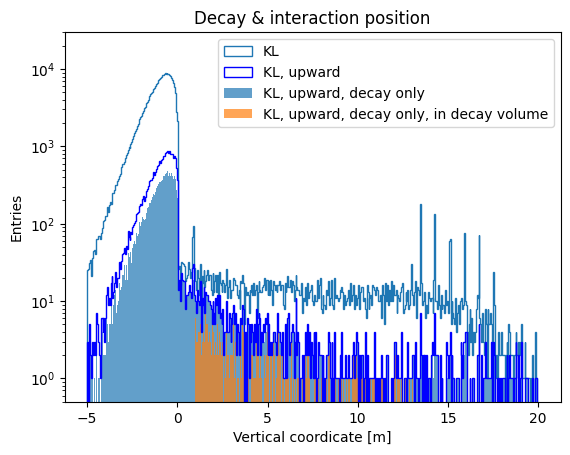

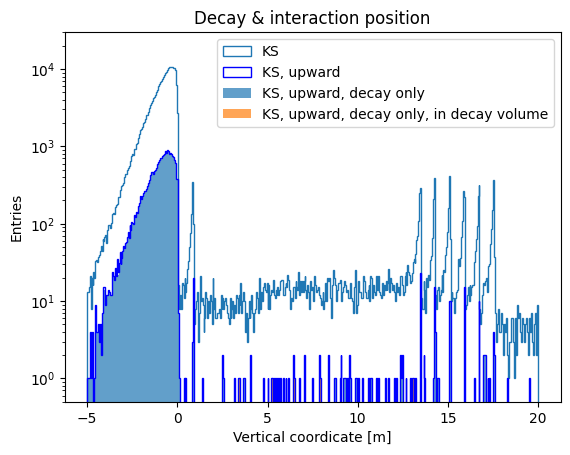

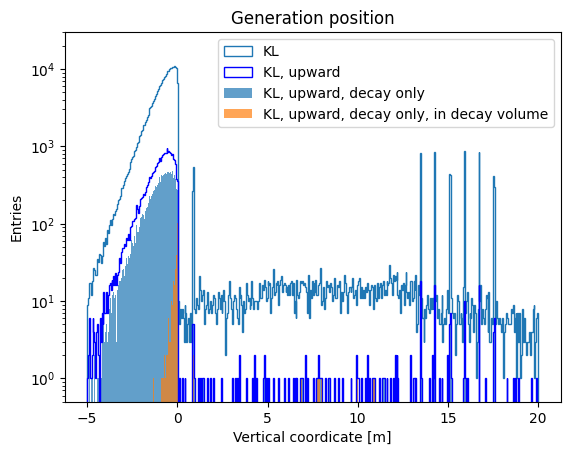

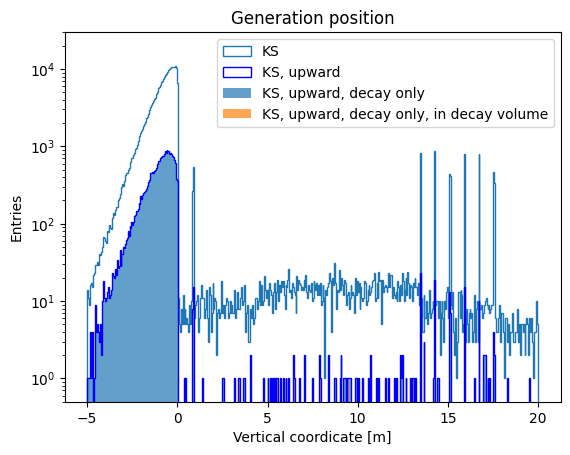

In [12]:
# bins_new = np.concatenate((np.linspace(-5,0,100), np.linspace(0,13.4, 50), np.linspace(13.4, 20, 50)))
hist(-k_z_end[mask_kl]/1000,bins=500, range=(-5,20),histtype="step", label="KL");
hist(-k_z_end[mask_kl&mask_upward]/1000,bins=500, range=(-5,20), histtype="step", color="blue", label="KL, upward");
hist(-k_z_end[mask_kl&mask_upward&mask_decay]/1000,bins=500, range=(-5,20),alpha=0.7, color="C0", label="KL, upward, decay only");
hist(-k_z_end[mask_kl&mask_upward&mask_decay&mask_inmathusla]/1000,bins=500, range=(-5,20),alpha=0.7, color="C1", label="KL, upward, decay only, in decay volume");

yscale("log")
xlabel("Vertical coordicate [m]")
ylabel("Entries")
legend()
title("Decay & interaction position")
ylim(0.5, 3e4)
show()

hist(-k_z_end[mask_ks]/1000,bins=500, range=(-5,20),histtype="step", label="KS");
hist(-k_z_end[mask_ks&mask_upward]/1000,bins=500, range=(-5,20), histtype="step", color="blue", label="KS, upward");
hist(-k_z_end[mask_ks&mask_upward&mask_decay]/1000,bins=500, range=(-5,20),alpha=0.7, color="C0", label="KS, upward, decay only");
hist(-k_z_end[mask_ks&mask_upward&mask_decay&mask_inmathusla]/1000,bins=500, range=(-5,20),alpha=0.7, color="C1", label="KS, upward, decay only, in decay volume");
yscale("log")
xlabel("Vertical coordicate [m]")
ylabel("Entries")
legend()
title("Decay & interaction position")
ylim(0.5, 3e4)
show()



# bins_new = np.concatenate((np.linspace(-5,0,100), np.linspace(0,13.4, 50), np.linspace(13.4, 20, 50)))
hist(-k_z[mask_kl]/1000,bins=500, range=(-5,20),histtype="step", label="KL");
hist(-k_z[mask_kl&mask_upward]/1000,bins=500, range=(-5,20), histtype="step", color="blue", label="KL, upward");
hist(-k_z[mask_kl&mask_upward&mask_decay]/1000,bins=500, range=(-5,20),alpha=0.7, color="C0", label="KL, upward, decay only");
hist(-k_z[mask_kl&mask_upward&mask_decay&mask_inmathusla]/1000,bins=500, range=(-5,20),alpha=0.7, color="C1", label="KL, upward, decay only, in decay volume");

yscale("log")
xlabel("Vertical coordicate [m]")
ylabel("Entries")
legend()
title("Generation position")
ylim(0.5, 3e4)
show()

hist(-k_z[mask_ks]/1000,bins=500, range=(-5,20),histtype="step", label="KS");
hist(-k_z[mask_ks&mask_upward]/1000,bins=500, range=(-5,20), histtype="step", color="blue", label="KS, upward");
hist(-k_z[mask_ks&mask_upward&mask_decay]/1000,bins=500, range=(-5,20),alpha=0.7, color="C0", label="KS, upward, decay only");
hist(-k_z[mask_ks&mask_upward&mask_decay&mask_inmathusla]/1000,bins=500, range=(-5,20),alpha=0.7, color="C1", label="KS, upward, decay only, in decay volume");
yscale("log")
xlabel("Vertical coordicate [m]")
ylabel("Entries")
legend()
title("Generation position")
ylim(0.5, 3e4)
show()

In [13]:
kz_klong_decay = -k_z[mask_sensitive&mask_kl]/1000
frac_kz_in_1m = sum((kz_klong_decay>-1)&(kz_klong_decay<0.1))/len(kz_klong_decay)
print("Fraction of KL generated in -1 to 0 m", frac_kz_in_1m)

Fraction of KL generated in -1 to 0 m 0.8823529411764706


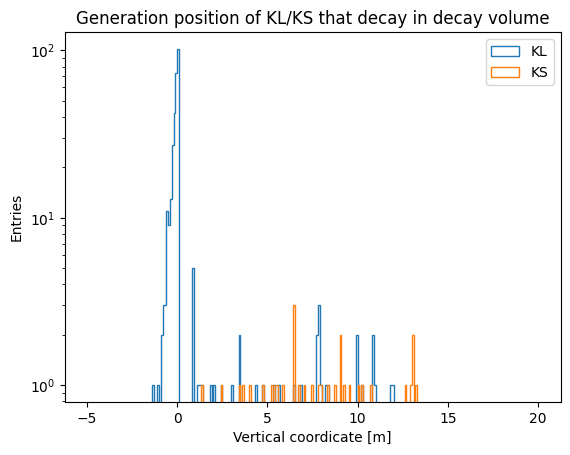

In [ ]:
bins = np.linspace(-5,20,251)
hist(-k_z[mask_sensitive&mask_kl]/1000,bins=bins, histtype="step", label="KL", color="C0");
hist(-k_z[mask_sensitive&mask_ks]/1000,bins=bins, histtype="step", label="KS", color="C1");
xlabel("Vertical coordicate [m]")
ylabel("Entries")
legend()
yscale("log")
title("Generation position of KL/KS that decay in decay volume")
show()


kz_klong_decay = -k_z[mask_sensitive&mask_kl]/1000
frac_kz_in_1m = sum((kz_klong_decay>-1)&(kz_klong_decay<0))/len(kz_klong_decay)
print("Fraction of KL decay in -1 to 0 m", frac_kz_in_1m)


scatter(k_x[mask_sensitive&mask_ks]/1000, k_y[mask_sensitive&mask_ks]/1000,s=1, label="KS", color="C1");
visualization.drawdet(2, axis=None, layer_height_vis=0.2, alpha=0.1, set_lim=False, unit="m")
title("Generation position of KS that decay in decay volume")
xlabel("Vertical coordicate [m]")
ylabel("Entries")
legend()
show()

scatter(k_x[mask_sensitive&mask_kl]/1000, k_y[mask_sensitive&mask_kl]/1000,s=1, label="KL", color="C0");
visualization.drawdet(2, axis=None, layer_height_vis=0.2, alpha=0.1, set_lim=False, unit="m")
title("Generation position of KL that decay in decay volume")
xlabel("Vertical coordicate [m]")
ylabel("Entries")
legend()
show()

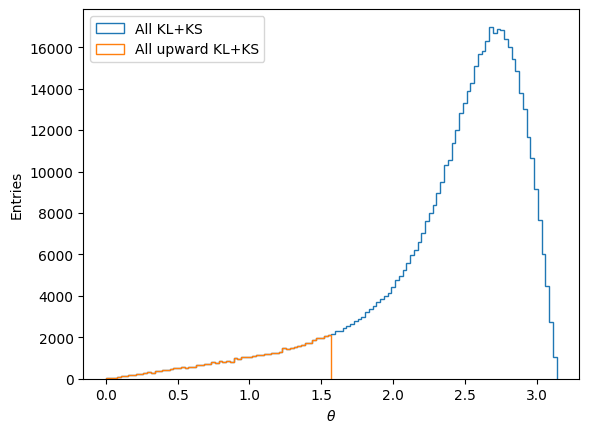

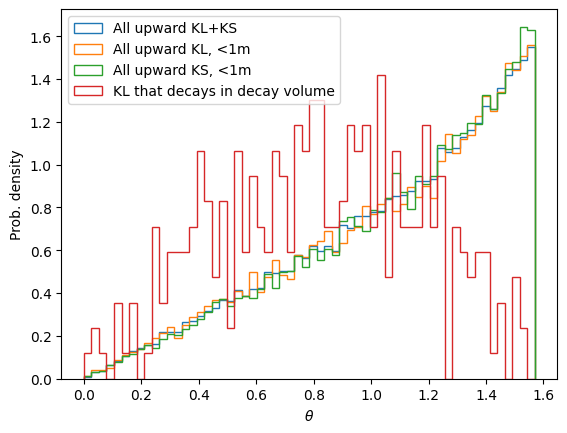

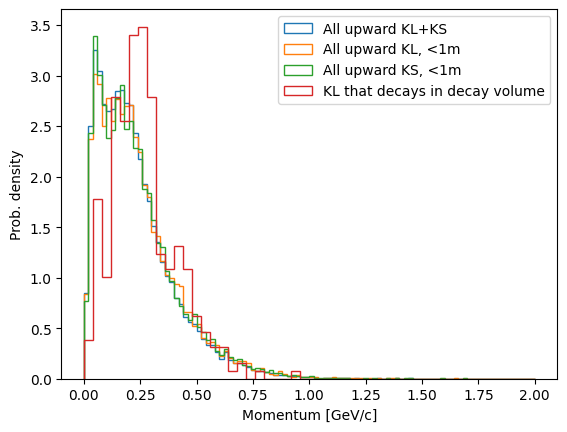

In [7]:
mask_close_to_surface = (-k_z/1000)>-1

hist(k_theta,bins=120, range=(0,3.14), density=False, histtype="step", label="All KL+KS");
hist(k_theta[mask_upward],bins=60, range=(0,3.14/2), density=False, histtype="step", label="All upward KL+KS");
xlabel(r"$\theta$")
ylabel("Entries")
legend()
show()

# hist(k_theta,bins=120, range=(0,3.14), density=True, histtype="step", label="All KL+KS");
hist(k_theta[mask_upward],bins=60, range=(0,3.14/2), density=True, histtype="step", label="All upward KL+KS");
hist(k_theta[mask_upward&mask_close_to_surface&mask_kl],bins=60, range=(0,3.14/2), density=True, histtype="step", label="All upward KL, <1m");
hist(k_theta[mask_upward&mask_close_to_surface&mask_ks],bins=60, range=(0,3.14/2), density=True, histtype="step", label="All upward KS, <1m");
hist(k_theta[mask_sensitive&mask_kl],bins=60, range=(0,3.14/2), density=True, histtype="step", label="KL that decays in decay volume");
xlabel(r"$\theta$")
ylabel("Prob. density")
legend()
show()

hist(0.001*k_pabs[mask_upward],bins=100, range=(0,2), density=True, histtype="step", label="All upward KL+KS");
hist(0.001*k_pabs[mask_upward&mask_close_to_surface&mask_kl],bins=100, range=(0,2), density=True, histtype="step", label="All upward KL, <1m");
hist(0.001*k_pabs[mask_upward&mask_close_to_surface&mask_ks],bins=100, range=(0,2), density=True, histtype="step", label="All upward KS, <1m");
hist(0.001*k_pabs[mask_sensitive&mask_kl],bins=50, range=(0,2), density=True, histtype="step", label="KL that decays in decay volume");
xlabel(r"Momentum [GeV/c]")
ylabel("Prob. density")
# yscale("log")
legend()
show()

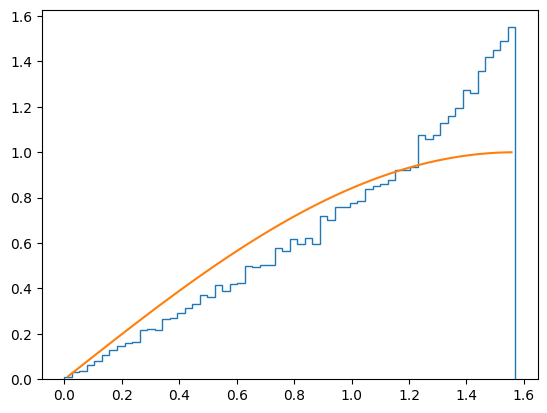

In [9]:
# x=np.linspace(0.01,3.14/2)
n,ibins,p = hist(k_theta[mask_upward],bins=60, range=(0,3.14/2), density=True, histtype="step", label="All upward KL+KS");
bincenters=0.5*(ibins[1:]+ibins[:-1])

y=np.sin(bincenters)
plot(bincenters,y)
# yscale('log')

### 3. Vertex

In [65]:
from muhelper import detector
det = detector.Detector()
import itertools

class Cut:
    
    CONST_CMS_LOC = np.array([0,0,0])
    CONST_VETO_LAYER = np.array([0,1,2,3])
    CONST_NOISE_RATE_SUPRESS = 0.1
    RNG = np.random.default_rng()
    
    @staticmethod
    def angel(v1,v2):
        mag1 = np.linalg.norm(v1)
        mag2 = np.linalg.norm(v2)
        opening_angle = np.arccos(np.dot(v1, v2)/( mag1*mag2 ))
        return opening_angle

    @staticmethod
    def vertex_updown(vertices, tracks):
        """
        Check which vertex is upward
        """
        upward_inds = []
        for i in range(len(vertices)):
            vertex = vertices[i]
            isupward=True
            for i in vertex.tracks:
                # All tracks need to go upwards
                if tracks[i].At<0:
                    isupward=False
                    break
            if isupward:
                upward_inds.append(i)

        return upward_inds

    @staticmethod
    def vertex_opening_angle(vertices, tracks, return_all=False):
        """
        Get the largest opening angle of all vetices, and the axis of the corresponding cone

        RETURN:
        ---
        open_angle: float
        direction: [kx, ky, kz]
        """
        open_angles = []
        directions = []
        for k1 in range(len(vertices)):
            vertex = vertices[k1]
            trackindices = vertex.tracks
            open_angles_i = []
            directions_i = []
            
            # Calculate opening angle for all combination of tracks within vertex
            combolist = list(itertools.combinations(trackindices, 2))
            for combo in combolist:
                combo = [int(combo[0]),int(combo[1])]

                track1, track2 = tracks[combo[0]], tracks[combo[1]]
                v1 = [track1.Ax/track1.At, 1/track1.At, track1.Az/track1.At]
                v2 = [track2.Ax/track2.At, 1/track2.At, track2.Az/track2.At]


                mag1 = np.linalg.norm(v1)
                mag2 = np.linalg.norm(v2)
                cos_opening_angle = np.dot(v1, v2)/( mag1*mag2 )

                direction = v1/mag1 + v2/mag2
                direction = direction/np.linalg.norm(direction)
                open_angles_i.append(np.arccos(cos_opening_angle))
                directions_i.append(direction)
                
            ind_i=np.argmax(open_angles_i)
            open_angles.append(open_angles_i[ind_i])
            directions.append(directions_i[ind_i])

        if return_all:
            return open_angles, directions
        else:
            # Get largest opening angle
            ind=np.argmax(open_angles)
            return open_angles[ind], directions[ind]
    
    @staticmethod
    def vertex_conatins_cms(vertices, tracks, margin=0):
        """check if any vertex contains the direction of CMS IP
        Return true if ANY vertex contains the CMS direction
        """    
        open_angles, directions = Cut.vertex_opening_angle(vertices, tracks, return_all=True)
        inds = []
        for i in range(len(directions)):
            direction_cms = np.array([vertices[i].x0, vertices[i].y0, vertices[i].z0]) - Cut.CONST_CMS_LOC
            half_open_angle = open_angles[i]/2
            angel_diff = Cut.angel(direction_cms, directions[i])
            if angel_diff<half_open_angle+margin:
                inds.append(i)
            
        return inds
            

    @staticmethod
    def vertex_n_tracks(vertices, tracks):
        ntrack=[len(vertex.tracks) for vertex in vertices]
        return max(ntrack)

    @staticmethod
    def vertex_min_chi2(vertices, tracks):
        chi2s=[vertex.chi2 for vertex in vertices]
        return min(chi2s)

    @staticmethod
    def vertex_inbox(vertices, tracks):
        inbox_inds=[]
        for i in range(len(vertices)):
            vertex=vertices[i]
            if det.inBox(vertex.x0,vertex.y0,vertex.z0):
                inbox_inds.append(i)

        return inbox_inds
    
    @staticmethod
    def vertex_veto_hits(vertices, tracks, hits, opening_angles=None, directions=None, vertex_inds=None):
        """
        Check the number of hits in veto layers
        """
        if opening_angles is None or directions is None:
            opening_angles, directions = Cut.vertex_opening_angle(vertices, tracks, return_all=True)
        if vertex_inds is None:
            vertex_inds = np.arange(len(vertices))
            
        n_veto_hits = []
        # For each vertex, count number of hits that is within the cone
        for i in vertex_inds:
            vertex_position = np.array([vertices[i].x0, vertices[i].y0, vertices[i].z0])
            vertex_direction = directions[i]
            vertex_halfangle = opening_angles[i]/2
            nhits=0
            for hit in hits:
                if hit.layer not in Cut.CONST_VETO_LAYER:
                    continue
                hit_direction = vertex_position - np.array([hit.x0, hit.y0, hit.z0])
                
                # Randomly drop the noise hits
                hit_type = hit.type
                
                
                if Cut.angle(hit_direction, vertex_direction) < vertex_halfangle:
                    nhits+=1
            n_veto_hits.append(nhits)
        return n_veto_hits    

In [50]:
def process_recon(filename):
    data=joblib.load(filename)
    nevents=len(data["hits"])
    nvertices=np.array([len(data["vertices"][i]) for i in range(nevents)])

    cut_info_keys = ["nvertex", "ntracks", "vertex_chi2min", "vertex_up", "vertex_inbox", "vertex_cms", "vertex_opening_angle", "vertex_theta"]
    cut_info={key:[] for key in cut_info_keys}
    for i in range(nevents):
        if len(data["vertices"][i])>0:
            tracks = data["tracks"][i]
            vertices=data["vertices"][i]
            ev_nvertex=len(vertices)
            ev_tracks_in_vertex = Cut.vertex_n_tracks(vertices, tracks)
            ev_vertex_chi2      = Cut.vertex_min_chi2(vertices, tracks)
            ev_has_upvertex     = Cut.vertex_updown(vertices, tracks)
            ev_vertex_inbox     = Cut.vertex_inbox(vertices, tracks)
            ev_vertex_cms       = Cut.vertex_conatins_cms(vertices, tracks)
            ev_vertex_opening, ev_vertex_direction= Cut.vertex_opening_angle(vertices, tracks)
            ev_vertex_theta = np.arccos(ev_vertex_direction[2]/np.linalg.norm(ev_vertex_direction))            
            
            cut_info["nvertex"].append(ev_nvertex)
            cut_info["ntracks"].append(ev_tracks_in_vertex)
            cut_info["vertex_chi2min"].append(ev_vertex_chi2)
            cut_info["vertex_up"].append(ev_has_upvertex)
            cut_info["vertex_inbox"].append(ev_vertex_inbox)
            cut_info["vertex_cms"].append(ev_vertex_cms)
            cut_info["vertex_opening_angle"].append(ev_vertex_opening)
            cut_info["vertex_theta"].append(ev_vertex_theta)
            
    for key in cut_info:
        cut_info[key] = np.array(cut_info[key])

    return cut_info

In [71]:
# filename=filename_recons[1]
filename='/project/rrg-mdiamond/data/MATHUSLA//simulation/run-2024-07-cosmic-proton//DigiOutput/cosmic_run_1/0/stat0.pkl'
data=joblib.load(filename)

# info = load_all(filename_recons[:1], loader=process_recon, datatype="list", verbose=True, list_append_axis=0)

In [77]:
data["hits"][5]

[Hit(x=1661.25, y=9427.718511989333, z=6998.2, t=1287.3547939508305, x_err=1.0103629710818451, y_err=13.416679869108547, z_err=0.2886751345948129, t_err=0.7071067811865475, layer=1, ind=0, det_id=166901, type=0)]

In [52]:
cut_info=info

In [6]:
# import pandas as pd
# frames = [pd.DataFrame(data["hits"][i]) for i in tqdm(range(len(data["hits"])))]

In [67]:
    cut_info_keys = ["nvertex", "ntracks", "vertex_chi2min", "vertex_up", "vertex_inbox", "vertex_cms", "vertex_opening_angle", "vertex_theta"]
    cut_info={key:[] for key in cut_info_keys}
    for i in range(nevents):
        if len(data["vertices"][i])>0:
            tracks = data["tracks"][i]
            vertices=data["vertices"][i]
            nvertex=len(vertices)
            tracks_in_vertex = Cut.vertex_n_tracks(vertices, tracks)
            vertex_chi2      = Cut.vertex_min_chi2(vertices, tracks)
            vertex_upward_inds  = Cut.vertex_updown(vertices, tracks)
            vertex_inbox_inds     = Cut.vertex_inbox(vertices, tracks)
            vertex_cms_inds       = Cut.vertex_conatins_cms(vertices, tracks)
            vertex_opening, ev_vertex_direction= Cut.vertex_opening_angle(vertices, tracks)
            vertex_theta = np.arcsin(ev_vertex_direction[0]/np.linalg.norm(ev_vertex_direction))            
            
            cut_info["nvertex"].append(nvertex)
            cut_info["ntracks"].append(tracks_in_vertex)
            cut_info["vertex_chi2min"].append(vertex_chi2)
            cut_info["vertex_up"].append(len(vertex_upward_inds))
            cut_info["vertex_inbox"].append(len(vertex_inbox_inds))
            cut_info["vertex_cms"].append(len(vertex_cms_inds))
            cut_info["vertex_opening_angle"].append(vertex_opening)
            cut_info["vertex_theta"].append(vertex_theta)
            
    for key in cut_info:
        cut_info[key] = np.array(cut_info[key])

In [62]:
mask_inbox = cut_info["vertex_inbox"]>0
mask_upward= cut_info["vertex_up"]>0
mask_cms = cut_info["vertex_cms"]>0

sum(mask_upward), sum(mask_inbox), sum(mask_cms), sum(mask_upward&mask_inbox&mask_cms)

(13, 111, 25, 0)

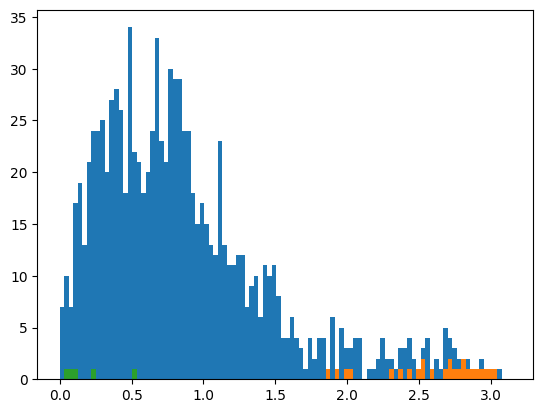

In [45]:
hist(cut_info["vertex_opening_angle"],bins=100, range=(0,3.14));
hist(cut_info["vertex_opening_angle"][mask_cms],bins=100, range=(0,3.14));
hist(cut_info["vertex_opening_angle"][mask_upward&mask_inbox],bins=100, range=(0,3.14));

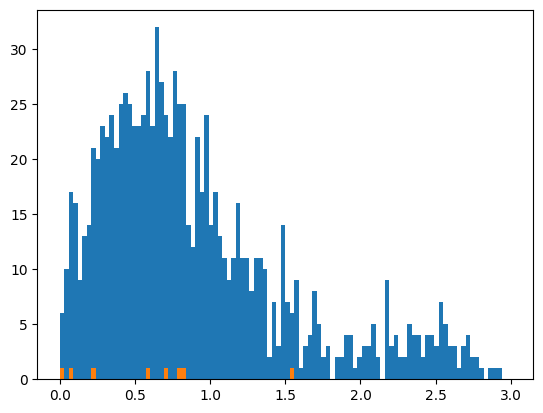

In [206]:
hist(info[:,5],bins=100, range=(0,3));
hist(info[:,5][mask_upward&mask_inbox],bins=100, range=(0,3));

In [96]:
# hist(info[:,5], bins=200, range=(0,12000))
# hist(info[:,5][mask_inbox], bins=200, range=(0,12000));
# hist(info[:,5][mask_upward&mask_inbox], bins=200, range=(0,12000));
# yscale("log")

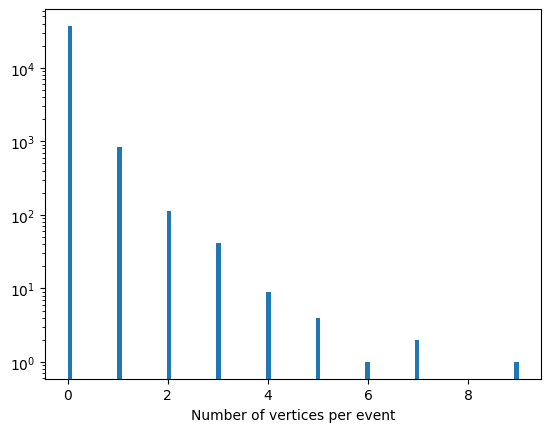

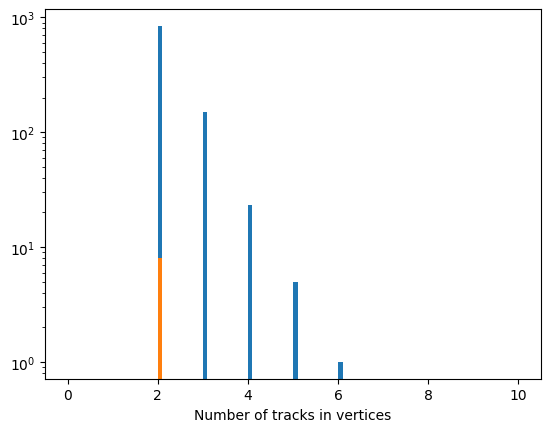

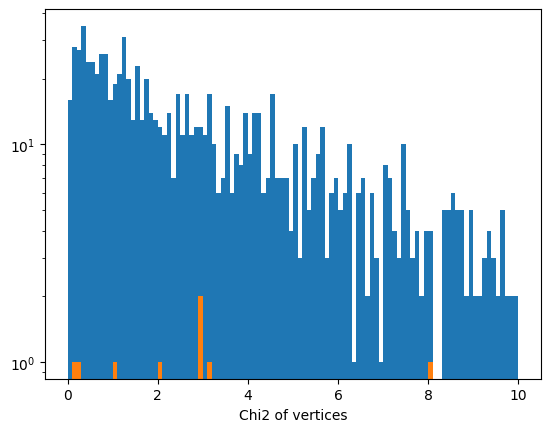

In [207]:
hist(nvertices, bins=100);
yscale("log")
xlabel("Number of vertices per event")
show()

hist(info[:,1], bins=100, range=(0,10));
hist(info[:,1][mask_upward&mask_inbox], bins=100, range=(0,10));
xlabel("Number of tracks in vertices")
yscale("log")
show()

hist(info[:,2], bins=100, range=(0,10));
hist(info[:,2][mask_upward&mask_inbox], bins=100, range=(0,10));
xlabel("Chi2 of vertices")
yscale("log")
show()


In [9]:
entries = info[:,-1][mask_upward&mask_inbox].astype(int)
entries

array([ 1483,  4911,  6215, 15098, 24087, 26898, 30392, 37943])

In [10]:
import tracker.io_user.io_MuSim as io
import muhelper.visualization as vis
import muhelper.helper_pytracker as hpt

In [11]:
filename_truth = filename_sims[1]

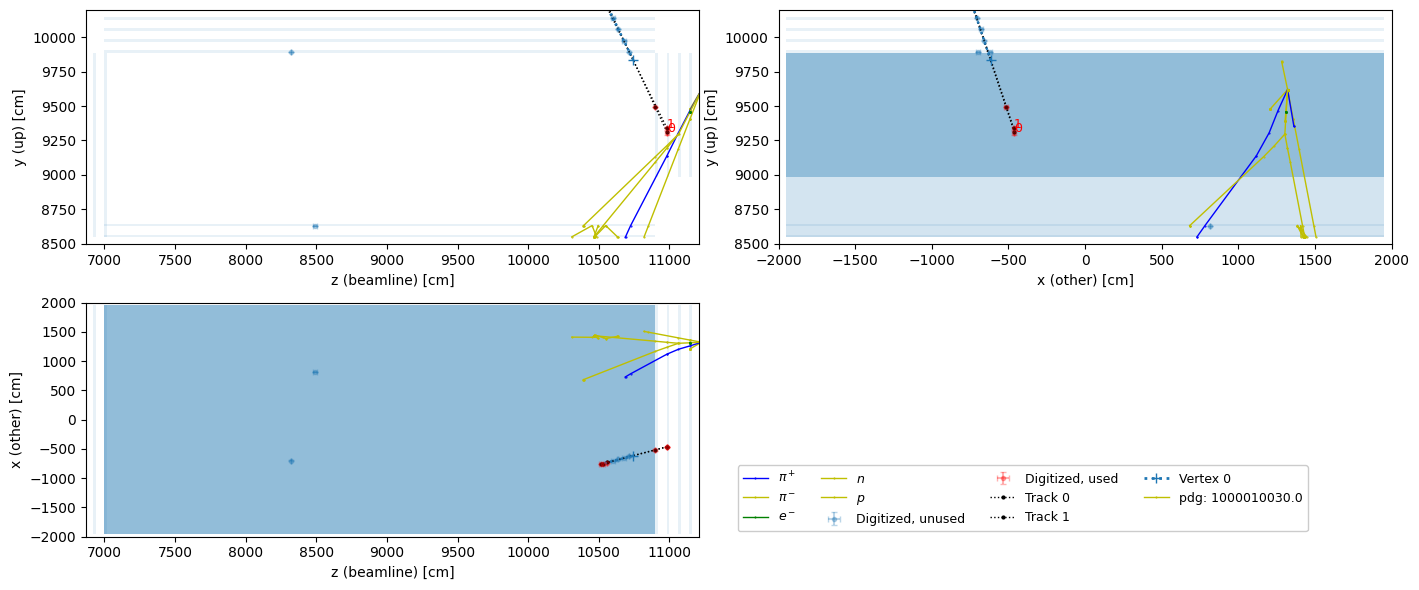

In [14]:
entry = entries[2]


tfile_truth = io.open(filename_truth)
Tree_truth  = io.get_tree(tfile_truth)

Tree_truth.GetEntry(entry)
hits, tracks, vertices = data["hits"][entry], data["tracks"][entry], data["vertices"][entry]


fig,axs=subplots(2,2,figsize=(14,6))
fig = vis.plot_truth_new(Tree_truth,fig=fig, disp_det_view=False, disp_filereader_vertex=False, disp_first_hit=False,make_legend=False);
fig = hpt.visualization.plot_recon(hits, tracks, vertices, fig=fig, make_legend=True)
fig = hpt.visualization.plot_det(fig=fig,set_lim=True, unit="cm")
axs = fig.axes

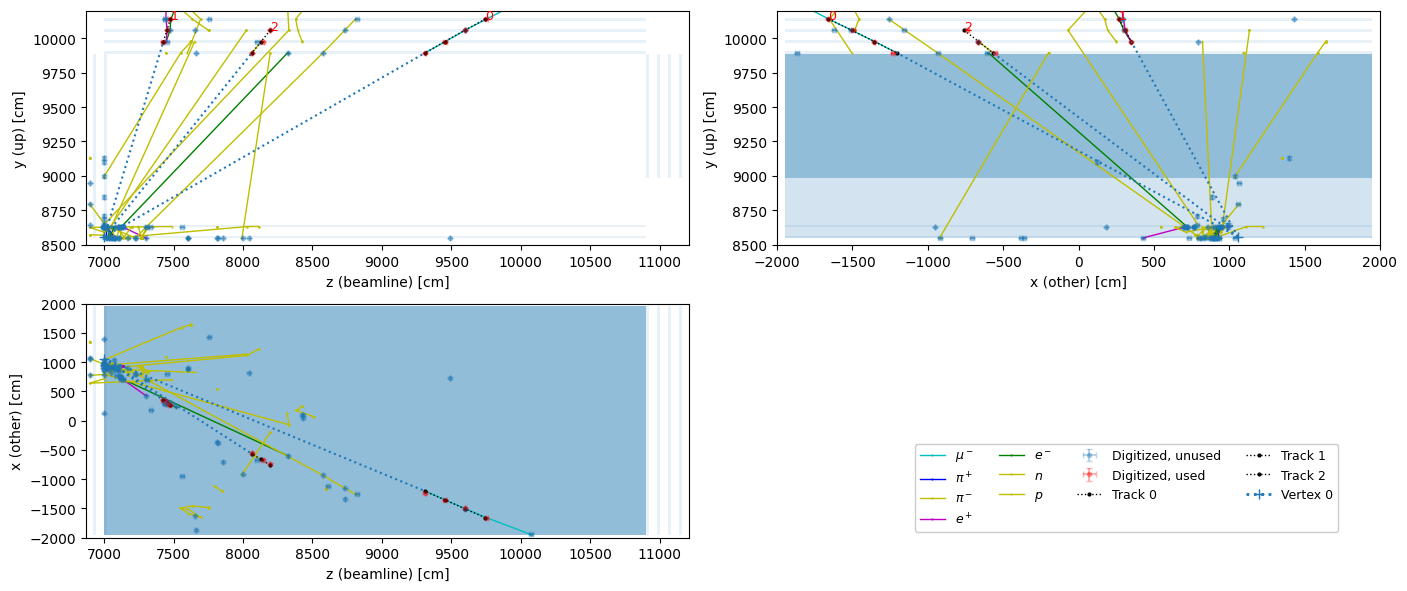

In [181]:
entry = entries[9]


tfile_truth = io.open(filename_truth)
Tree_truth  = io.get_tree(tfile_truth)

Tree_truth.GetEntry(entry)
hits, tracks, vertices = data["hits"][entry], data["tracks"][entry], data["vertices"][entry]


fig,axs=subplots(2,2,figsize=(14,6))
fig = vis.plot_truth_new(Tree_truth,fig=fig, disp_det_view=False, disp_filereader_vertex=False, disp_first_hit=False,make_legend=False);
fig = hpt.visualization.plot_recon(hits, tracks, vertices, fig=fig, make_legend=True)
fig = hpt.visualization.plot_det(fig=fig,set_lim=True, unit="cm")
axs = fig.axes

---
# Check HITS

In [15]:
filename_root="/project/6049244/data/MATHUSLA/simulation/run-2024-07-17/20240725/150632/run0.root" # 10 GeV, 2000 events


tfile = ROOT.TFile.Open(filename_root)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)
entries = Tree.GetEntries()
branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
print(entries, branches)

1 ['X_START', 'X_END', 'Z_START', 'Z_END', 'Wall_START', 'Wall_END', 'BACK_START', 'BACK_END', 'LENGTH', 'WIDTH', 'THICKNESS', 'MODULE_X', 'LAYERS_Y', 'MODULE_Z', 'FLOOR_Y', 'WALL_Z', 'BACK_Z']


---
# Check step data

In [116]:
# filename_root="/home/tomren/jupyter/Background_gen/Mu-Background/studies/cosmic_proton/step_data/event_20.root" # 10 GeV, 2000 events


# tfile = ROOT.TFile.Open(filename_root)
# tree_name = tfile.GetListOfKeys()[0].GetName()
# Tree = tfile.Get(tree_name)
# entries = Tree.GetEntries()
# branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
# print(entries, branches)

# df=ROOT.RDataFrame(tree_name, filename_root)
# data=df.AsNumpy()

In [2]:
filename_root="/project/rrg-mdiamond/data/MATHUSLA//simulation/run-2024-07-cosmic-proton/SimOutput/cosmic/run_0/20240725/182411/run_step_data.root" # 10 GeV, 2000 events


tfile = ROOT.TFile.Open(filename_root)
tree_names = [i.GetName() for i in  tfile.GetListOfKeys()]

Tree = tfile.Get(tree_names[0])
entries = Tree.GetEntries()
branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
print(entries, branches)



0 ['X_S', 'Y_S', 'Z_S', 'X_END_S', 'Y_END_S', 'Z_END_S', 'PX_S', 'PY_S', 'PZ_S', 'DE', 'DEPOSIT', 'PDG', 'TRACK', 'TRACK_PARENT', 'MATERIAL']


In [34]:
# def extract_kaon_event(data):
#     mask=[]
#     data_masked={}
#     for i in range(len(data["PDG"])):
#         if (data["PDG"][i] in [130,310]) & (data["TRACK"][i] not in data["TRACK_PARENT"]):
#             mask.append(True)
#         else:
#             mask.append(False)
#     for key in data:
#         data_masked[key]=data[key][mask]
#     return data_masked

# def extract_kaon(filename_root):
#     # Using dataframe
#     tfile = ROOT.TFile.Open(filename_root)
#     tree_names = [i.GetName() for i in  tfile.GetListOfKeys()]  
    
#     results = []
#     for tree_name in tqdm(tree_names):
#         Tree = tfile.Get(tree_name)
#         entries = Tree.GetEntries()
#         if entries!=0:
#             df=ROOT.RDataFrame(tree_name, filename_root)
#             data=df.AsNumpy()
#             # print(data["PDG"], data["TRACK"], data["TRACK_PARENT"], data["Z_S"], data["Z_END_S"])
#             data = extract_kaon_event(data)
#             results.append(data)
            
#     return results


# def extract_kaon_event_fast(branches):
#     data=[]
#     entries = branches["PDG"].GetEntries()
#     for entry in range(entries)
#         pdg = branches["PDG"].GetEntry(entry)
    
#     return data

# def extract_kaon_fast(filename_root):
#     # Using dataframe
#     tfile = ROOT.TFile.Open(filename_root)
#     tree_names = [i.GetName() for i in  tfile.GetListOfKeys()]  
    
#     results = []
#     for tree_name in tqdm(tree_names):
#         Tree = tfile.Get(tree_name)
#         branch_names = ["PDG","TRACK","TRACK_PARENT",'X_S', 'Y_S', 'Z_S', 'X_END_S', 'Y_END_S', 'Z_END_S', 'PX_S', 'PY_S', 'PZ_S']
#         branches = {var:Tree.GetBranch(var) for var in branch_names}
        
#         if entries!=0:
#             data = extract_kaon_event_fast(branches)
#             results.extend(data)
            
#     return results

In [35]:
results = extract_kaon(filename_root)

100%|██████████| 527/527 [00:00<00:00, 584.27it/s]
